<font color="black" face="Times New Roman" size="6"><b> Import Libraries </b></font> 

In [1]:
import ord_schema
from ord_schema import message_helpers, validations
from ord_schema.proto import dataset_pb2

import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wget

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn import model_selection, metrics
from glob import glob
import gzip
import shutil
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

<font color="black" face="Times New Roman" size="6"><b> Data Exploring and Preparing </b></font> 

In [2]:
url = "https://github.com/open-reaction-database/ord-data/blob/main/data/68/ord_dataset-68cb8b4b2b384e3d85b5b1efae58b203.pb.gz?raw=true"
pb = wget.download(url)

100% [............................................................................] 269731 / 269731

In [3]:
with gzip.open(pb, "rb") as f:
    decompressed_data = f.read()
    with open("ord_dataset.pb", "wb") as out_file:
        out_file.write(decompressed_data)
data = message_helpers.load_message("ord_dataset.pb", dataset_pb2.Dataset)

In [4]:
valid_output = validations.validate_message(data)

In [5]:
df = message_helpers.messages_to_dataframe(data.reactions, drop_constant_columns=True)
df

,"inputs[""Base in Solvent""].components[0].identifiers[0].value","inputs[""Base in Solvent""].components[0].amount.moles.value","inputs[""Base in Solvent""].components[0].amount.moles.units","inputs[""Base in Solvent""].components[0].reaction_role","inputs[""Base in Solvent""].components[1].identifiers[0].type","inputs[""Base in Solvent""].components[1].identifiers[0].value","inputs[""Base in Solvent""].components[1].amount.volume.value","inputs[""Base in Solvent""].components[1].amount.volume.units","inputs[""Base in Solvent""].components[1].reaction_role","inputs[""Boronate in Solvent""].components[0].identifiers[0].value",...,"inputs[""Ligand in Solvent""].components[1].reaction_role","inputs[""Aryl Halide""].components[0].identifiers[0].value",outcomes[0].products[0].measurements[0].percentage.value,provenance.record_modified[1].time.value,reaction_id,"inputs[""Ligand in Solvent""].components[0].amount.volume.value","inputs[""Ligand in Solvent""].components[0].amount.volume.units","inputs[""Ligand in Solvent""].components[0].amount.volume_includes_solutes","inputs[""Base in Solvent""].components[0].amount.volume.value","inputs[""Base in Solvent""].components[0].amount.volume.units"
0,[OH-].[Na+],1.0,MICROMOLE,REAGENT,SMILES,O,1.0,MICROLITER,SOLVENT,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,...,SOLVENT,ClC1=CC=C2N=CC=CC2=C1,4.760000,2021-03-04 13:56:15.292871,ord-61b2819b15824f1fa131ed1b2ea1dae4,NaN,NaN,NaN,NaN,NaN
1,[OH-].[Na+],1.0,MICROMOLE,REAGENT,SMILES,O,1.0,MICROLITER,SOLVENT,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,...,SOLVENT,ClC1=CC=C2N=CC=CC2=C1,4.120000,2021-03-04 13:56:15.298402,ord-f18c2b2d0bd04d2c96a3a16dfd8b8bef,NaN,NaN,NaN,NaN,NaN
2,[OH-].[Na+],1.0,MICROMOLE,REAGENT,SMILES,O,1.0,MICROLITER,SOLVENT,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,...,SOLVENT,ClC1=CC=C2N=CC=CC2=C1,2.580000,2021-03-04 13:56:15.303978,ord-1061f43c594b4de68345c010b2aef94b,NaN,NaN,NaN,NaN,NaN
3,[OH-].[Na+],1.0,MICROMOLE,REAGENT,SMILES,O,1.0,MICROLITER,SOLVENT,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,...,SOLVENT,ClC1=CC=C2N=CC=CC2=C1,4.440000,2021-03-04 13:56:15.309572,ord-e61614af430845179c392e478d958383,NaN,NaN,NaN,NaN,NaN
4,[OH-].[Na+],1.0,MICROMOLE,REAGENT,SMILES,O,1.0,MICROLITER,SOLVENT,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,...,SOLVENT,ClC1=CC=C2N=CC=CC2=C1,1.950000,2021-03-04 13:56:15.315080,ord-3fede496f4284a5ea6656f083e2399ae,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,[O-]P(=O)([O-])[O-].[K+].[K+].[K+],1.0,MICROMOLE,REAGENT,SMILES,O,1.0,MICROLITER,SOLVENT,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,...,SOLVENT,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,47.209999,2021-03-04 13:56:49.737623,ord-b498385d41664713aaef79a290409614,NaN,NaN,NaN,NaN,NaN
5756,[O-]P(=O)([O-])[O-].[K+].[K+].[K+],1.0,MICROMOLE,REAGENT,SMILES,O,1.0,MICROLITER,SOLVENT,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,...,SOLVENT,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,0.000000,2021-03-04 13:56:49.743574,ord-2ef787f9faac4077bff2d903866aa209,NaN,NaN,NaN,NaN,NaN
5757,[O-]P(=O)([O-])[O-].[K+].[K+].[K+],1.0,MICROMOLE,REAGENT,SMILES,O,1.0,MICROLITER,SOLVENT,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,...,SOLVENT,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,31.440001,2021-03-04 13:56:49.749090,ord-654740d21331471cafdfda41ff19d57a,NaN,NaN,NaN,NaN,NaN
5758,[O-]P(=O)([O-])[O-].[K+].[K+].[K+],1.0,MICROMOLE,REAGENT,SMILES,O,1.0,MICROLITER,SOLVENT,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,...,SOLVENT,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,0.000000,2021-03-04 13:56:49.754742,ord-8e53efc193e548ba888b47da3e91ced5,NaN,NaN,NaN,NaN,NaN


In [6]:
list(df.columns)

['inputs["Base in Solvent"].components[0].identifiers[0].value',
 'inputs["Base in Solvent"].components[0].amount.moles.value',
 'inputs["Base in Solvent"].components[0].amount.moles.units',
 'inputs["Base in Solvent"].components[0].reaction_role',
 'inputs["Base in Solvent"].components[1].identifiers[0].type',
 'inputs["Base in Solvent"].components[1].identifiers[0].value',
 'inputs["Base in Solvent"].components[1].amount.volume.value',
 'inputs["Base in Solvent"].components[1].amount.volume.units',
 'inputs["Base in Solvent"].components[1].reaction_role',
 'inputs["Boronate in Solvent"].components[0].identifiers[0].value',
 'inputs["Boronate in Solvent"].components[1].identifiers[0].value',
 'inputs["Solvent_1"].components[0].identifiers[0].value',
 'inputs["Ligand in Solvent"].components[0].identifiers[0].value',
 'inputs["Ligand in Solvent"].components[0].amount.moles.value',
 'inputs["Ligand in Solvent"].components[0].amount.moles.units',
 'inputs["Ligand in Solvent"].components[0

In [7]:
model_cols = [
    'inputs["Aryl Halide"].components[0].identifiers[0].value',
    'inputs["Boronate in Solvent"].components[0].identifiers[0].value',
    'inputs["Ligand in Solvent"].components[0].identifiers[0].value',
    'inputs["Base in Solvent"].components[0].identifiers[0].value',
    'inputs["Solvent_1"].components[0].identifiers[0].value',
    'outcomes[0].products[0].measurements[0].percentage.value',]
df = df[model_cols]
df

,"inputs[""Aryl Halide""].components[0].identifiers[0].value","inputs[""Boronate in Solvent""].components[0].identifiers[0].value","inputs[""Ligand in Solvent""].components[0].identifiers[0].value","inputs[""Base in Solvent""].components[0].identifiers[0].value","inputs[""Solvent_1""].components[0].identifiers[0].value",outcomes[0].products[0].measurements[0].percentage.value
0,ClC1=CC=C2N=CC=CC2=C1,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,CC(C)(C)P(C(C)(C)C)C(C)(C)C,[OH-].[Na+],CC#N,4.760000
1,ClC1=CC=C2N=CC=CC2=C1,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,c1ccc(cc1)P(c2ccccc2)c3ccccc3,[OH-].[Na+],CC#N,4.120000
2,ClC1=CC=C2N=CC=CC2=C1,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,CC(C)(C)P(C1=CC=C(C=C1)N(C)C)C(C)(C)C.CC(C)(C)...,[OH-].[Na+],CC#N,2.580000
3,ClC1=CC=C2N=CC=CC2=C1,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,C1CCC(CC1)P(C2CCCCC2)C3CCCCC3,[OH-].[Na+],CC#N,4.440000
4,ClC1=CC=C2N=CC=CC2=C1,B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,Cc1ccccc1P(c2ccccc2C)c3ccccc3C,[OH-].[Na+],CC#N,1.950000
...,...,...,...,...,...,...
5755,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,CC(C)(C)P([C]1[CH][CH][CH][CH]1)C(C)(C)C.CC(C)...,[O-]P(=O)([O-])[O-].[K+].[K+].[K+],CN(C)C=O,47.209999
5756,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,CC(C)c1cc(c(c(c1)C(C)C)c2ccccc2P(C3CCCCC3)C4CC...,[O-]P(=O)([O-])[O-].[K+].[K+].[K+],CN(C)C=O,0.000000
5757,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,c1ccc(cc1)P([c-]2cccc2)c3ccccc3.c1ccc(cc1)P([c...,[O-]P(=O)([O-])[O-].[K+].[K+].[K+],CN(C)C=O,31.440001
5758,BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,CC1(c2cccc(c2Oc3c1cccc3P(c4ccccc4)c5ccccc5)P(c...,[O-]P(=O)([O-])[O-].[K+].[K+].[K+],CN(C)C=O,0.000000


In [8]:
print(f"Number of NaN values: {df.isnull().sum().sum()}")

Number of NaN values: 0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 6 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   inputs["Aryl Halide"].components[0].identifiers[0].value          5760 non-null   object 
 1   inputs["Boronate in Solvent"].components[0].identifiers[0].value  5760 non-null   object 
 2   inputs["Ligand in Solvent"].components[0].identifiers[0].value    5760 non-null   object 
 3   inputs["Base in Solvent"].components[0].identifiers[0].value      5760 non-null   object 
 4   inputs["Solvent_1"].components[0].identifiers[0].value            5760 non-null   object 
 5   outcomes[0].products[0].measurements[0].percentage.value          5760 non-null   float64
dtypes: float64(1), object(5)
memory usage: 270.1+ KB


In [10]:
df.describe()

,outcomes[0].products[0].measurements[0].percentage.value
count,5760.000000
mean,40.109446
std,28.081087
min,0.000000
25%,16.197501
50%,33.580000
75%,62.870001
max,100.000000


<font color="black" face="Times New Roman" size="6"><b> Dataset Shaping </b></font> 

In [11]:
input_cols = model_cols[:-1]
prefix = ["electrophile", "nucleophile", "ligand", "base", "solvent"]
ohe_df = pd.get_dummies(df[input_cols], prefix=prefix)
ohe_df["yield"] = df[model_cols[-1]] / 100
ohe_df

,electrophile_BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,electrophile_BrC1=CC=C2N=CC=CC2=C1,electrophile_ClC1=CC=C2N=CC=CC2=C1,electrophile_IC1=CC=C2N=CC=CC2=C1,electrophile_O=S(OC1=CC=C2N=CC=CC2=C1)(C(F)(F)F)=O,nucleophile_B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,nucleophile_CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,nucleophile_Cc1ccc2n(C3CCCCO3)ncc2c1B4OC(C)(C)C(C)(C)O4,nucleophile_F[B-](F)(C1=C(C)C=CC2=C1C=NN2C3CCCCO3)F.[K+],nucleophile_OB(C1=CC=C2N=CC=CC2=C1)O.[H]Cl,...,base_[F-].[Cs+],base_[Li+].CC(C)(C)[O-],base_[O-]P(=O)([O-])[O-].[K+].[K+].[K+],base_[OH-].[K+],base_[OH-].[Na+],solvent_C1CCOC1,solvent_CC#N,solvent_CN(C)C=O,solvent_CO,yield
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0.0476
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0.0412
2,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0.0258
3,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0.0444
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0.0195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0.4721
5756,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0.0000
5757,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0.3144
5758,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0.0000


In [12]:
X = ohe_df.drop(columns=["yield"]).values
y = ohe_df["yield"].values
X.shape, y.shape

((5760, 35), (5760,))

In [13]:
X_train, X_temp, y_train, y_temp = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)
X_test, X_val, y_test, y_val = model_selection.train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((4032, 35), (864, 35), (864, 35), (4032,), (864,), (864,))

<font color="black" face="Times New Roman" size="6"><b> Artificial Neural Network Model </b></font> 

In [14]:
def objective(trial):
    # Parameters
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)

    # Model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=X_train.shape[1]))

    for i in range(num_layers):
        num_units = trial.suggest_int(f"num_units_layer_{i}", 4, 128, log=True)
        model.add(tf.keras.layers.Dense(num_units, activation="relu"))

    model.add(tf.keras.layers.Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

    # Training Model
    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=100,
        verbose=0,)

    score = model.evaluate(X_val, y_val, verbose=0)
    return score[0]  


# Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Best Parameters
print("Best parameters: ", study.best_trial.params)

[I 2023-08-19 12:36:21,584] A new study created in memory with name: no-name-4dff60f8-99ad-4676-be05-6f45120df465
G:\pyton\anaconda\envs\main_env\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  after removing the cwd from sys.path.
[I 2023-08-19 12:37:08,762] Trial 0 finished with value: 0.025445597246289253 and parameters: {'num_layers': 1, 'learning_rate': 0.0005254246997792112, 'num_units_layer_0': 5}. Best is trial 0 with value: 0.025445597246289253.
[I 2023-08-19 12:37:51,877] Trial 1 finished with value: 0.02637079544365406 and parameters: {'num_layers': 1, 'learning_rate': 0.015075958633202454, 'num_units_layer_0': 4}. Best is trial 0 with value: 0.025445597246289253.
[I 2023-08-19 12:38:45,967] Trial 2 finished with value: 0.035223331302404404 and parameters: {'num_layers': 3, 'l

[I 2023-08-19 13:04:50,645] Trial 31 finished with value: 0.017490673810243607 and parameters: {'num_layers': 2, 'learning_rate': 0.0006716664881183297, 'num_units_layer_0': 51, 'num_units_layer_1': 4}. Best is trial 4 with value: 0.011867591179907322.
[I 2023-08-19 13:05:52,039] Trial 32 finished with value: 0.016121994704008102 and parameters: {'num_layers': 2, 'learning_rate': 0.0016980909946222175, 'num_units_layer_0': 42, 'num_units_layer_1': 5}. Best is trial 4 with value: 0.011867591179907322.
[I 2023-08-19 13:06:56,469] Trial 33 finished with value: 0.016841646283864975 and parameters: {'num_layers': 2, 'learning_rate': 0.0008344149184017557, 'num_units_layer_0': 101, 'num_units_layer_1': 7}. Best is trial 4 with value: 0.011867591179907322.
[I 2023-08-19 13:07:57,199] Trial 34 finished with value: 0.015502437017858028 and parameters: {'num_layers': 2, 'learning_rate': 0.00022065684484675753, 'num_units_layer_0': 64, 'num_units_layer_1': 5}. Best is trial 4 with value: 0.011867

[I 2023-08-19 13:32:01,755] Trial 62 finished with value: 0.012114370241761208 and parameters: {'num_layers': 3, 'learning_rate': 0.005532437720957756, 'num_units_layer_0': 114, 'num_units_layer_1': 94, 'num_units_layer_2': 14}. Best is trial 49 with value: 0.010607234202325344.
[I 2023-08-19 13:32:59,439] Trial 63 finished with value: 0.012366791255772114 and parameters: {'num_layers': 3, 'learning_rate': 0.009464653523217102, 'num_units_layer_0': 92, 'num_units_layer_1': 112, 'num_units_layer_2': 19}. Best is trial 49 with value: 0.010607234202325344.
[I 2023-08-19 13:33:56,660] Trial 64 finished with value: 0.01572585105895996 and parameters: {'num_layers': 3, 'learning_rate': 0.02356946800012807, 'num_units_layer_0': 128, 'num_units_layer_1': 74, 'num_units_layer_2': 12}. Best is trial 49 with value: 0.010607234202325344.
[I 2023-08-19 13:34:52,784] Trial 65 finished with value: 0.01451130397617817 and parameters: {'num_layers': 3, 'learning_rate': 0.02747930063692588, 'num_units_l

[I 2023-08-19 14:00:31,848] Trial 92 finished with value: 0.012369790114462376 and parameters: {'num_layers': 3, 'learning_rate': 0.013518694678805173, 'num_units_layer_0': 83, 'num_units_layer_1': 98, 'num_units_layer_2': 11}. Best is trial 75 with value: 0.0104157580062747.
[I 2023-08-19 14:01:27,717] Trial 93 finished with value: 0.014809920452535152 and parameters: {'num_layers': 3, 'learning_rate': 0.017527577910103075, 'num_units_layer_0': 121, 'num_units_layer_1': 87, 'num_units_layer_2': 16}. Best is trial 75 with value: 0.0104157580062747.
[I 2023-08-19 14:02:32,992] Trial 94 finished with value: 0.010983587242662907 and parameters: {'num_layers': 3, 'learning_rate': 0.007658850254554454, 'num_units_layer_0': 91, 'num_units_layer_1': 128, 'num_units_layer_2': 16}. Best is trial 75 with value: 0.0104157580062747.
[I 2023-08-19 14:03:30,215] Trial 95 finished with value: 0.011681401170790195 and parameters: {'num_layers': 3, 'learning_rate': 0.00788747450519341, 'num_units_layer

Best parameters:  {'num_layers': 3, 'learning_rate': 0.004359057595304307, 'num_units_layer_0': 120, 'num_units_layer_1': 81, 'num_units_layer_2': 8}


27/27 [==============================] - 0s 3ms/step


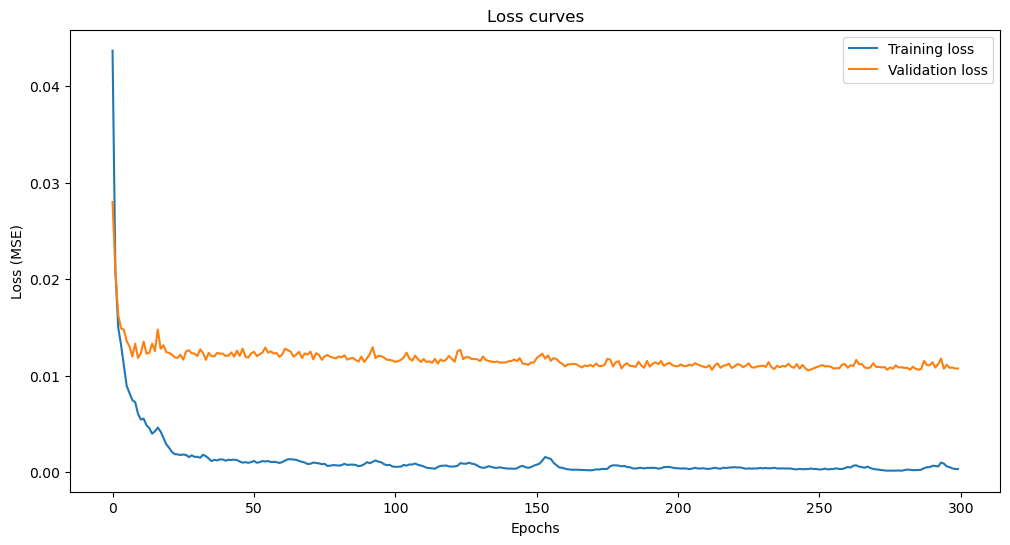

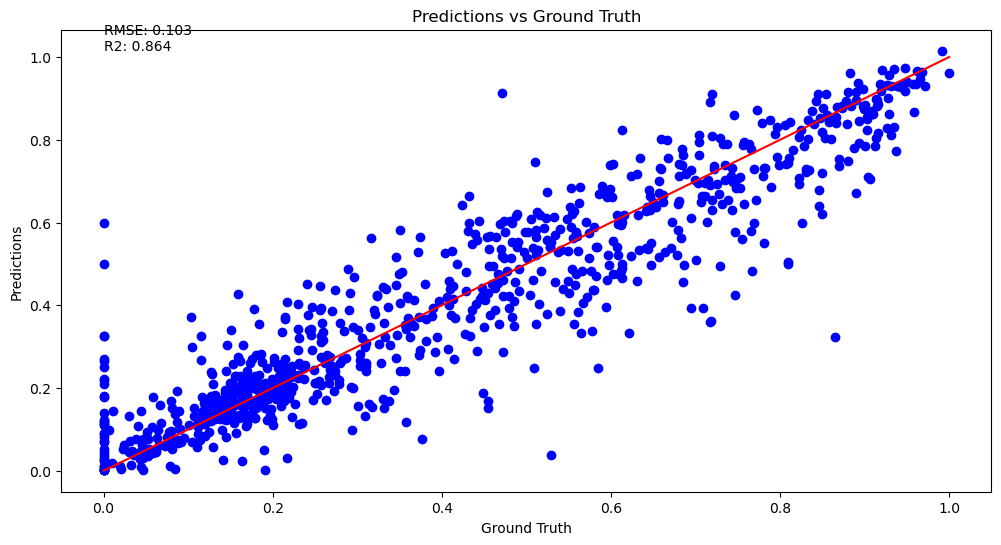

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(120, activation="relu"),  # num_units_layer_0: 120 - best
    tf.keras.layers.Dense(81, activation="relu"),  # num_units_layer_1: 81 - best
    tf.keras.layers.Dense(8, activation="relu"),  # num_units_layer_2: 8 - best
    tf.keras.layers.Dense(1)])

model.compile(optimizer=tf.keras.optimizers.Adam(0.004359057595304307),
              loss=tf.keras.losses.MeanSquaredError())
# Trening best Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=100, verbose=0)

# Predictions
preds = model.predict(X_test)

# RMSE and R2 results
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

# Plots

# Plot loss through training
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.title("Loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

# Plot predictions vs ground truth
plt.figure(figsize=(12, 6))
plt.scatter(y_test, preds, c="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red")
plt.title("Predictions vs Ground Truth")
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.text(min(y_test), max(preds), f"RMSE: {round(rmse, 3)}\nR2: {round(r2, 3)}")
plt.show()

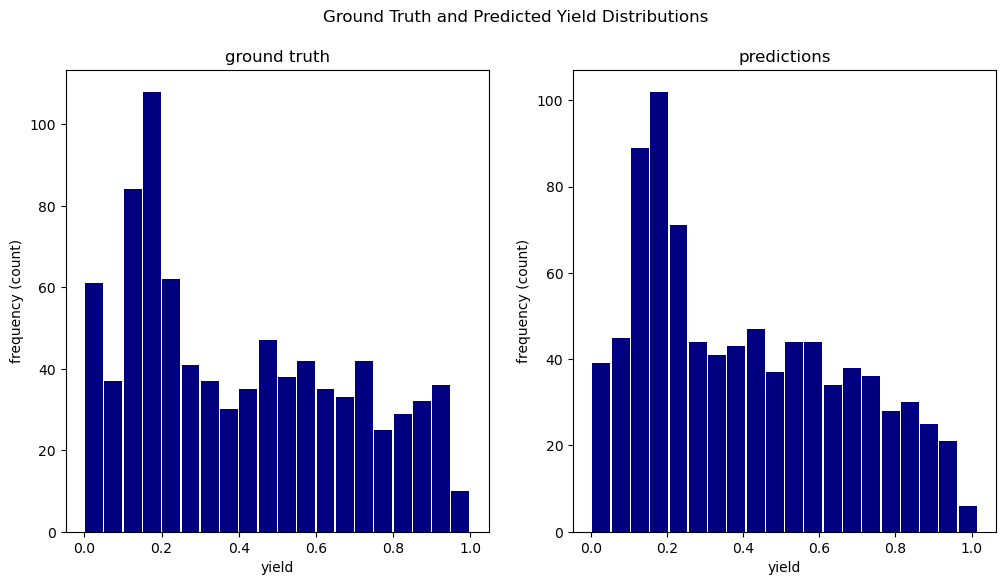

In [16]:
# Show ground truth and predicted yield distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Ground Truth and Predicted Yield Distributions")

# Plot ground truth histogram
ax1.hist(y_test, bins=20, rwidth=0.93, color="navy")
ax1.set_title("ground truth")
ax1.set_xlabel("yield")
ax1.set_ylabel("frequency (count)")

# Plot predicted histogram
ax2.hist(preds, bins=20, rwidth=0.93, color="navy")
ax2.set_title("predictions")
ax2.set_xlabel("yield")
ax2.set_ylabel("frequency (count)")

# View distributions
plt.show()

In [17]:
#Results
mae = mean_absolute_error(y_test, preds)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

RMSE: 0.10315447266869701
MAE: 0.07107601456097284
R2: 0.864217179618079


<font color="black" face="Times New Roman" size="6"><b> Lasso Model </b></font> 

In [19]:
# LassoCV
model_lasso = LassoCV(cv=5) 

# Lasso fitting to train
model_lasso.fit(X_train, y_train)

# Alpha
print("Best alpha using LassoCV: %f" % model_lasso.alpha_)

# Predictions
preds_lasso = model_lasso.predict(X_test)

# Results
rmse_lasso = np.sqrt(mean_squared_error(y_test, preds_lasso))
mae_lasso = mean_absolute_error(y_test, preds_lasso)
r2_lasso = r2_score(y_test, preds_lasso)

print(f"RMSE: {rmse_lasso}")
print(f"MAE: {mae_lasso}")
print(f"R2: {r2_lasso}")

Best alpha using LassoCV: 0.000039
RMSE: 0.19825618190164007
MAE: 0.16506806369661667
R2: 0.4984408300772799


<font color="black" face="Times New Roman" size="6"><b> Ridge Model </b></font> 

In [20]:
# Define alpha for Model
alpha_range = np.logspace(-4, 1, 50)

# Ridge Model
ridge_model = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])

# Define parameters grid for Model
param_grid = {"ridge__alpha": alpha_range}

# GridSearchCV
grid = GridSearchCV(ridge_model, param_grid, cv=5, scoring="neg_mean_squared_error")

# GridSearchCV fitting 
grid.fit(X_train, y_train)

# WThe best Model
best_model_ridge = grid.best_estimator_

# Predictions for best Model
test_preds_best = best_model_ridge.predict(X_test)

# Results
rmse_test_best = np.sqrt(mean_squared_error(y_test, test_preds_best))
mae_test_best = mean_absolute_error(y_test, test_preds_best)
r2_test_best = r2_score(y_test, test_preds_best)

print(f"Best alpha: {grid.best_params_['ridge__alpha']}")
print(f"Test RMSE: {rmse_test_best}")
print(f"Test MAE: {mae_test_best}")
print(f"Test R2: {r2_test_best}")

Best alpha: 10.0
Test RMSE: 0.19829059047683983
Test MAE: 0.165076922853118
Test R2: 0.4982667176348815


<font color="black" face="Times New Roman" size="6"><b> XGB Model </b></font> 

In [21]:
# Define the parameters for XGB Model
param_grid_xgb = {"n_estimators": [100, 200, 300], "learning_rate": [0.01, 0.05, 0.1], "max_depth": [3, 4, 5], 
                  "subsample": [0.7, 0.8, 0.9], "colsample_bytree": [0.7, 0.8, 0.9],}

# XGBRegressor Model
xgb = XGBRegressor(objective ="reg:squarederror")

# GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring="neg_mean_squared_error", verbose=2)

# Train Model
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best parameters found: ",grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estima

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estima

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estima

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200,

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, n_estimators=300, subsample=0.9; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, n_estimators=300, subsample=0.9; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, n_estimators=300, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, n_estimators=300, subsample=0.9; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100,

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estima

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estima

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estima

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estima

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100,

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200,

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estima

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.8s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.8s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.9s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.7; total time=   1.7s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estima

[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=4, n_estima

[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.9; total time=   1.4s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, n_estima

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200,

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9; total time=   1.5s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9; total time=   1.4s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9; total time=   1.4s
Best parameters found:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


In [22]:
# Predictions for the best Model
best_xgb = grid_search.best_estimator_
test_preds_xgb = best_xgb.predict(X_test)

# Results
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, test_preds_xgb))
mae_test_xgb = mean_absolute_error(y_test, test_preds_xgb)
r2_test_xgb = r2_score(y_test, test_preds_xgb)

print(f"Test RMSE: {rmse_test_xgb}")
print(f"Test MAE: {mae_test_xgb}")
print(f"Test R2: {r2_test_xgb}")

Test RMSE: 0.11303519629062034
Test MAE: 0.08248206350354141
Test R2: 0.8369592800598354


<font color="black" face="Times New Roman" size="6"><b> Decision Tree Model</b></font> 

In [23]:
# Define the parameters for Decision Tree
param_grid = {"max_depth": range(1, 20), "min_samples_split": range(2, 20),}

# Posible Model
dt = DecisionTreeRegressor(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error", verbose=2)

# Train Model 
grid_search.fit(X_train, y_train)


# Predictions for the best Model
best_model = grid_search.best_estimator_

# Train the best Model and best parameters
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")


# Results for Decision Tree Model
test_preds = grid_search.predict(X_test)
rmse_test_tree = np.sqrt(mean_squared_error(y_test, test_preds))
mae_test_tree = mean_absolute_error(y_test, test_preds)
r2_test_tree = r2_score(y_test, test_preds)

print(f"Test RMSE_tree: {rmse_test_tree}")
print(f"Test MAE_tree: {mae_test_tree}")
print(f"Test R2_tree: {r2_test_tree}")

Fitting 5 folds for each of 342 candidates, totalling 1710 fits
[CV] END ...................max_depth=1, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=1, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=1, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=1, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=1, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=1, min_samples_split=3; total time=   0.0s
[CV] END ...................max_depth=1, min_samples_split=3; total time=   0.0s
[CV] END ...................max_depth=1, min_samples_split=3; total time=   0.0s
[CV] END ...................max_depth=1, min_samples_split=3; total time=   0.0s
[CV] END ...................max_depth=1, min_samples_split=3; total time=   0.0s
[CV] END ...................max_depth=1, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=1, min_

[CV] END ...................max_depth=2, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=6; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=6; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=6; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=3, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=9; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=9; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=9; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=9; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=9; total time=   0.0s
[CV] END ..................max_depth=3, min_samples_split=10; total time=   0.0s
[CV] END ..................max_depth=3, min_samples_split=10; total time=   0.0s
[CV] END ..................m

[CV] END ..................max_depth=4, min_samples_split=12; total time=   0.0s
[CV] END ..................max_depth=4, min_samples_split=12; total time=   0.0s
[CV] END ..................max_depth=4, min_samples_split=12; total time=   0.0s
[CV] END ..................max_depth=4, min_samples_split=12; total time=   0.0s
[CV] END ..................max_depth=4, min_samples_split=12; total time=   0.0s
[CV] END ..................max_depth=4, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=4, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=4, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=4, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=4, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=4, min_samples_split=14; total time=   0.0s
[CV] END ..................max_depth=4, min_samples_split=14; total time=   0.0s
[CV] END ..................m

[CV] END ..................max_depth=5, min_samples_split=18; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=18; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=18; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=18; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=19; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=19; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=19; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=19; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=19; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_split=2; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=7, min_samples_split=6; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=6; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=6; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=7; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=7; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=7; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=7; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=7; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=8; total time=   0.0s
[CV] END ...................

[CV] END ..................max_depth=8, min_samples_split=10; total time=   0.0s
[CV] END ..................max_depth=8, min_samples_split=10; total time=   0.0s
[CV] END ..................max_depth=8, min_samples_split=10; total time=   0.0s
[CV] END ..................max_depth=8, min_samples_split=10; total time=   0.0s
[CV] END ..................max_depth=8, min_samples_split=11; total time=   0.0s
[CV] END ..................max_depth=8, min_samples_split=11; total time=   0.0s
[CV] END ..................max_depth=8, min_samples_split=11; total time=   0.0s
[CV] END ..................max_depth=8, min_samples_split=11; total time=   0.0s
[CV] END ..................max_depth=8, min_samples_split=11; total time=   0.0s
[CV] END ..................max_depth=8, min_samples_split=12; total time=   0.0s
[CV] END ..................max_depth=8, min_samples_split=12; total time=   0.0s
[CV] END ..................max_depth=8, min_samples_split=12; total time=   0.0s
[CV] END ..................m

[CV] END ..................max_depth=9, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=14; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=14; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=14; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=14; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=14; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=15; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=15; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=15; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=15; total time=   0.0s
[CV] END ..................m

[CV] END .................max_depth=10, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=19; total time=   0.0s
[CV] END ..................max_depth=11, min_samples_split=2; total time=   0.0s
[CV] END ..................max_depth=11, min_samples_split=2; total time=   0.0s
[CV] END ..................max_depth=11, min_samples_split=2; total time=   0.0s
[CV] END ..................m

[CV] END ..................max_depth=12, min_samples_split=4; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_split=4; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_split=5; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_split=5; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_split=5; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_split=5; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_split=5; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_split=6; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_split=6; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_split=6; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_split=6; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_split=6; total time=   0.0s
[CV] END ..................m

[CV] END ..................max_depth=13, min_samples_split=7; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=8; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=8; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=8; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=8; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=8; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=9; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=9; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=9; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=9; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=9; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=10; total time=   0.0s
[CV] END .................ma

[CV] END .................max_depth=14, min_samples_split=10; total time=   0.0s
[CV] END .................max_depth=14, min_samples_split=10; total time=   0.0s
[CV] END .................max_depth=14, min_samples_split=10; total time=   0.0s
[CV] END .................max_depth=14, min_samples_split=10; total time=   0.0s
[CV] END .................max_depth=14, min_samples_split=11; total time=   0.0s
[CV] END .................max_depth=14, min_samples_split=11; total time=   0.0s
[CV] END .................max_depth=14, min_samples_split=11; total time=   0.0s
[CV] END .................max_depth=14, min_samples_split=11; total time=   0.0s
[CV] END .................max_depth=14, min_samples_split=11; total time=   0.0s
[CV] END .................max_depth=14, min_samples_split=12; total time=   0.0s
[CV] END .................max_depth=14, min_samples_split=12; total time=   0.0s
[CV] END .................max_depth=14, min_samples_split=12; total time=   0.0s
[CV] END .................ma

[CV] END .................max_depth=15, min_samples_split=15; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=15; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=15; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=15; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=15; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=16; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=16; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=16; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=16; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=16; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=17; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=17; total time=   0.0s
[CV] END .................ma

[CV] END .................max_depth=16, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=19; total time=   0.0s
[CV] END ..................max_depth=17, min_samples_split=2; total time=   0.0s
[CV] END ..................max_depth=17, min_samples_split=2; total time=   0.0s
[CV] END ..................max_depth=17, min_samples_split=2; total time=   0.0s
[CV] END ..................max_depth=17, min_samples_split=2; total time=   0.0s
[CV] END ..................max_depth=17, min_samples_split=2; total time=   0.0s
[CV] END ..................m

[CV] END ..................max_depth=18, min_samples_split=5; total time=   0.0s
[CV] END ..................max_depth=18, min_samples_split=5; total time=   0.0s
[CV] END ..................max_depth=18, min_samples_split=5; total time=   0.0s
[CV] END ..................max_depth=18, min_samples_split=5; total time=   0.0s
[CV] END ..................max_depth=18, min_samples_split=6; total time=   0.0s
[CV] END ..................max_depth=18, min_samples_split=6; total time=   0.0s
[CV] END ..................max_depth=18, min_samples_split=6; total time=   0.0s
[CV] END ..................max_depth=18, min_samples_split=6; total time=   0.0s
[CV] END ..................max_depth=18, min_samples_split=6; total time=   0.0s
[CV] END ..................max_depth=18, min_samples_split=7; total time=   0.0s
[CV] END ..................max_depth=18, min_samples_split=7; total time=   0.0s
[CV] END ..................max_depth=18, min_samples_split=7; total time=   0.0s
[CV] END ..................m

[CV] END .................max_depth=19, min_samples_split=10; total time=   0.0s
[CV] END .................max_depth=19, min_samples_split=10; total time=   0.0s
[CV] END .................max_depth=19, min_samples_split=10; total time=   0.0s
[CV] END .................max_depth=19, min_samples_split=10; total time=   0.0s
[CV] END .................max_depth=19, min_samples_split=11; total time=   0.0s
[CV] END .................max_depth=19, min_samples_split=11; total time=   0.0s
[CV] END .................max_depth=19, min_samples_split=11; total time=   0.0s
[CV] END .................max_depth=19, min_samples_split=11; total time=   0.0s
[CV] END .................max_depth=19, min_samples_split=11; total time=   0.0s
[CV] END .................max_depth=19, min_samples_split=12; total time=   0.0s
[CV] END .................max_depth=19, min_samples_split=12; total time=   0.0s
[CV] END .................max_depth=19, min_samples_split=12; total time=   0.0s
[CV] END .................ma

[CV] END ..................max_depth=1, min_samples_split=14; total time=   0.0s
[CV] END ..................max_depth=1, min_samples_split=14; total time=   0.0s
[CV] END ..................max_depth=1, min_samples_split=14; total time=   0.0s
[CV] END ..................max_depth=1, min_samples_split=14; total time=   0.0s
[CV] END ..................max_depth=1, min_samples_split=15; total time=   0.0s
[CV] END ..................max_depth=1, min_samples_split=15; total time=   0.0s
[CV] END ..................max_depth=1, min_samples_split=15; total time=   0.0s
[CV] END ..................max_depth=1, min_samples_split=15; total time=   0.0s
[CV] END ..................max_depth=1, min_samples_split=15; total time=   0.0s
[CV] END ..................max_depth=1, min_samples_split=16; total time=   0.0s
[CV] END ..................max_depth=1, min_samples_split=16; total time=   0.0s
[CV] END ..................max_depth=1, min_samples_split=16; total time=   0.0s
[CV] END ..................m

[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=3; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=3; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=3; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=3; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=3; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=3, min_samples_split=4; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=4, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=4, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=4, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=4, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=4, min_samples_split=9; total time=   0.0s
[CV] END ...................max_depth=4, min_samples_split=9; total time=   0.0s
[CV] END ...................max_depth=4, min_samples_split=9; total time=   0.0s
[CV] END ...................max_depth=4, min_samples_split=9; total time=   0.0s
[CV] END ...................max_depth=4, min_samples_split=9; total time=   0.0s
[CV] END ..................max_depth=4, min_samples_split=10; total time=   0.0s
[CV] END ..................max_depth=4, min_samples_split=10; total time=   0.0s
[CV] END ..................max_depth=4, min_samples_split=10; total time=   0.0s
[CV] END ..................m

[CV] END ..................max_depth=5, min_samples_split=15; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=15; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=15; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=15; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=15; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=16; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=16; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=16; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=16; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=16; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=17; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=17; total time=   0.0s
[CV] END ..................m

[CV] END ...................max_depth=7, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=3; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=3; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=3; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=3; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=3; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=7, min_samples_split=4; total time=   0.0s
[CV] END ...................

[CV] END ...................max_depth=8, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=8, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=8, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=8, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=8, min_samples_split=8; total time=   0.0s
[CV] END ...................max_depth=8, min_samples_split=9; total time=   0.0s
[CV] END ...................max_depth=8, min_samples_split=9; total time=   0.0s
[CV] END ...................max_depth=8, min_samples_split=9; total time=   0.0s
[CV] END ...................max_depth=8, min_samples_split=9; total time=   0.0s
[CV] END ...................max_depth=8, min_samples_split=9; total time=   0.0s
[CV] END ..................max_depth=8, min_samples_split=10; total time=   0.0s
[CV] END ..................max_depth=8, min_samples_split=10; total time=   0.0s
[CV] END ..................m

[CV] END ..................max_depth=9, min_samples_split=11; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=11; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=11; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=12; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=12; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=12; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=12; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=12; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=13; total time=   0.0s
[CV] END ..................m

[CV] END .................max_depth=10, min_samples_split=14; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=15; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=15; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=15; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=15; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=15; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=16; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=16; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=16; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=16; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=16; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=17; total time=   0.0s
[CV] END .................ma

[CV] END .................max_depth=11, min_samples_split=17; total time=   0.0s
[CV] END .................max_depth=11, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=11, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=11, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=11, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=11, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=11, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=11, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=11, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=11, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=11, min_samples_split=19; total time=   0.0s
[CV] END ..................max_depth=12, min_samples_split=2; total time=   0.0s
[CV] END ..................m

[CV] END ..................max_depth=13, min_samples_split=2; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=3; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=3; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=3; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=3; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=3; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=4; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=4; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=4; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=4; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=4; total time=   0.0s
[CV] END ..................max_depth=13, min_samples_split=5; total time=   0.0s
[CV] END ..................m

[CV] END ..................max_depth=14, min_samples_split=5; total time=   0.0s
[CV] END ..................max_depth=14, min_samples_split=5; total time=   0.0s
[CV] END ..................max_depth=14, min_samples_split=5; total time=   0.0s
[CV] END ..................max_depth=14, min_samples_split=6; total time=   0.0s
[CV] END ..................max_depth=14, min_samples_split=6; total time=   0.0s
[CV] END ..................max_depth=14, min_samples_split=6; total time=   0.0s
[CV] END ..................max_depth=14, min_samples_split=6; total time=   0.0s
[CV] END ..................max_depth=14, min_samples_split=6; total time=   0.0s
[CV] END ..................max_depth=14, min_samples_split=7; total time=   0.0s
[CV] END ..................max_depth=14, min_samples_split=7; total time=   0.0s
[CV] END ..................max_depth=14, min_samples_split=7; total time=   0.0s
[CV] END ..................max_depth=14, min_samples_split=7; total time=   0.0s
[CV] END ..................m

[CV] END ..................max_depth=15, min_samples_split=8; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_split=8; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_split=9; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_split=9; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_split=9; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_split=9; total time=   0.0s
[CV] END ..................max_depth=15, min_samples_split=9; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=10; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=10; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=10; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=10; total time=   0.0s
[CV] END .................max_depth=15, min_samples_split=10; total time=   0.0s
[CV] END .................ma

[CV] END .................max_depth=16, min_samples_split=13; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=13; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=13; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=13; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=14; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=14; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=14; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=14; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=14; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=15; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=15; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=15; total time=   0.0s
[CV] END .................ma

[CV] END .................max_depth=17, min_samples_split=17; total time=   0.0s
[CV] END .................max_depth=17, min_samples_split=17; total time=   0.0s
[CV] END .................max_depth=17, min_samples_split=17; total time=   0.0s
[CV] END .................max_depth=17, min_samples_split=17; total time=   0.0s
[CV] END .................max_depth=17, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=17, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=17, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=17, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=17, min_samples_split=18; total time=   0.0s
[CV] END .................max_depth=17, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=17, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=17, min_samples_split=19; total time=   0.0s
[CV] END .................ma

[CV] END .................max_depth=18, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=18, min_samples_split=19; total time=   0.0s
[CV] END ..................max_depth=19, min_samples_split=2; total time=   0.1s
[CV] END ..................max_depth=19, min_samples_split=2; total time=   0.0s
[CV] END ..................max_depth=19, min_samples_split=2; total time=   0.0s
[CV] END ..................max_depth=19, min_samples_split=2; total time=   0.0s
[CV] END ..................max_depth=19, min_samples_split=2; total time=   0.0s
[CV] END ..................max_depth=19, min_samples_split=3; total time=   0.0s
[CV] END ..................max_depth=19, min_samples_split=3; total time=   0.0s
[CV] END ..................max_depth=19, min_samples_split=3; total time=   0.0s
[CV] END ..................max_depth=19, min_samples_split=3; total time=   0.0s
[CV] END ..................max_depth=19, min_samples_split=3; total time=   0.0s
[CV] END ..................m

<font color="black" face="Times New Roman" size="6"><b>Results </b></font> 

In [24]:
RMSE_dict = {}
MAE_dict = {}
R2_dict = {}

In [25]:
model_list = ["Neutral Network", "Lasso", "Ridge", "XGB", "Tree"]  
rmse_list = [rmse, rmse_lasso, rmse_test_best, rmse_test_xgb, rmse_test_tree]  
mae_list = [mae, mae_lasso, mae_test_best, mae_test_xgb, mae_test_tree]  
r2_list = [r2, r2_lasso, r2_test_best, r2_test_xgb, r2_test_tree]  

for i, model_name in enumerate(model_list):
    RMSE_dict[model_name] = rmse_list[i]
for i, model_name in enumerate(model_list):
    MAE_dict[model_name] = mae_list[i]
for i, model_name in enumerate(model_list):
    R2_dict[model_name] = r2_list[i]

In [26]:
new_RMSE_dict = dict.fromkeys(model_list, 0)
new_MAE_dict = dict.fromkeys(model_list, 0)
new_R2_dict = dict.fromkeys(model_list, 0)

for i, model_name in enumerate(model_list):
    new_RMSE_dict[model_name] = rmse_list[i]
    new_MAE_dict[model_name] = mae_list[i]
    new_R2_dict[model_name] = r2_list[i]

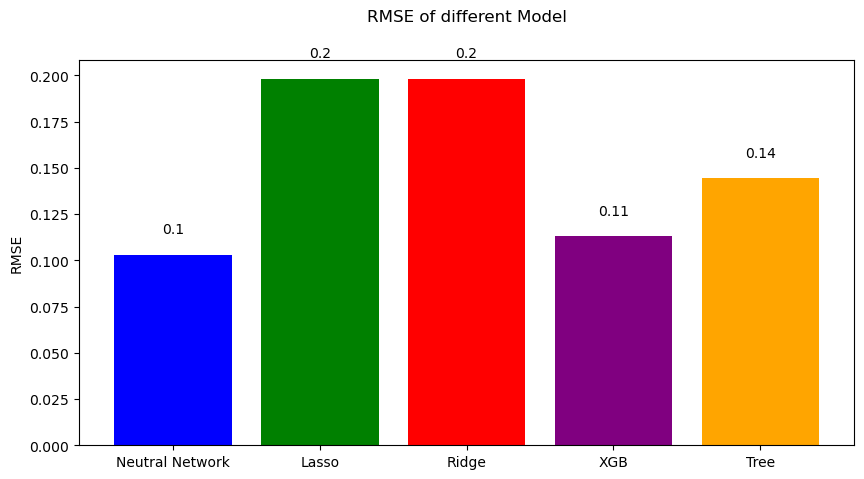

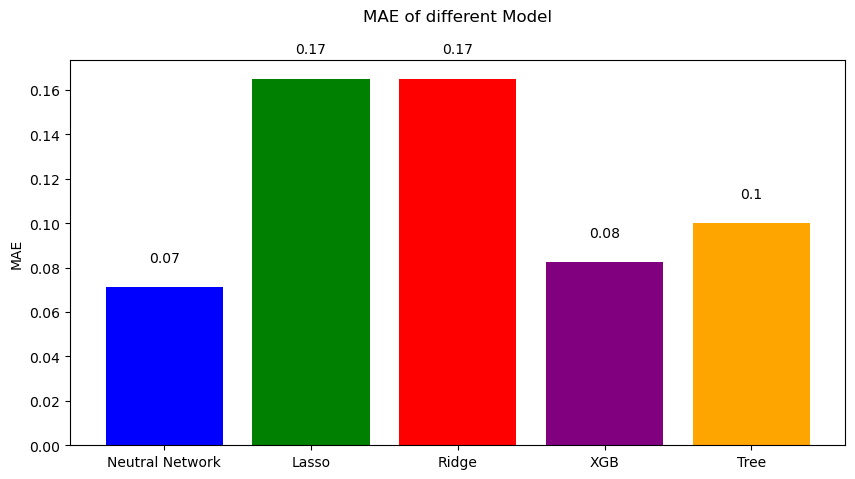

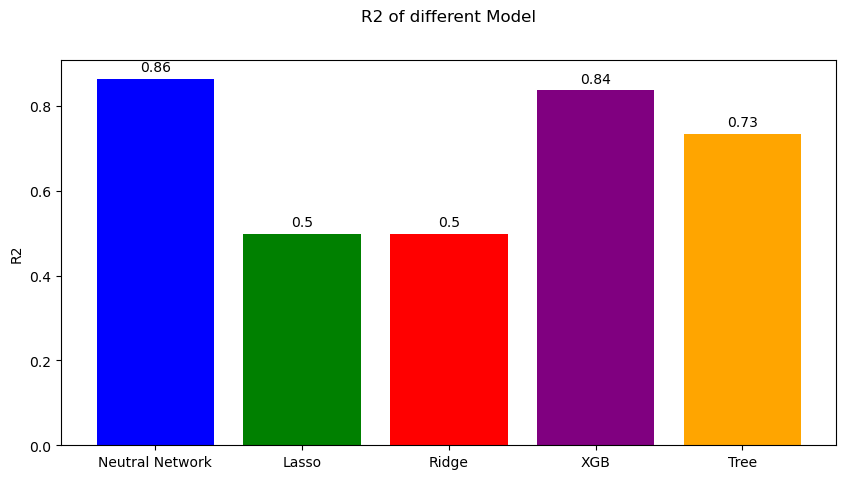

In [27]:
def plot_metrics(metrics_dict, title, ylabel):
    names = list(metrics_dict.keys())
    values = list(metrics_dict.values())
    colors = ["blue", "green", "red", "purple", "orange"]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(names, values, color=colors)
    plt.title(title, y=1.08)
    plt.ylabel(ylabel)
    
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha="center", va="bottom")
    
    plt.show()


plot_metrics(new_RMSE_dict, "RMSE of different Model", "RMSE")
plot_metrics(new_MAE_dict, "MAE of different Model", "MAE")
plot_metrics(new_R2_dict, "R2 of different Model", "R2")